### LSTM Forecast Prediction model

In [162]:
# installing packages (if required)
!pip install scalecast
!pip install scikeras

In [163]:
# Import packages

from scalecast.Forecaster import Forecaster
from scalecast.MVForecaster import MVForecaster
from scalecast.multiseries import export_model_summaries
from scalecast import GridGenerator
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from google.colab import drive
import os
from scikeras.wrappers import KerasRegressor
from sklearn.model_selection import GridSearchCV
from math import sqrt
import json
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

In [164]:
# Import the csv file
file_path = 'data/df_daily.csv'

df_ori = pd.read_csv(file_path, parse_dates=['datetime'], index_col='datetime')


In [166]:
# Make a copy of the original dataframe
df = df_ori.copy()
df.columns

Index(['total_real_power', 'reactive_power', 'voltage', 'current_intensity',
       'kitchen', 'laundry_room', 'temp_control'],
      dtype='object')

In [167]:
#Let's check the correlation between the variables - correlation matrix
df_corr = df.corr()

print('\nCorrelation matrix:')
print(df_corr)


Correlation matrix:
                   total_real_power  reactive_power   voltage  \
total_real_power           1.000000        0.042327  0.127280   
reactive_power             0.042327        1.000000 -0.050627   
voltage                    0.127280       -0.050627  1.000000   
current_intensity          0.999181        0.064038  0.101661   
kitchen                    0.545054        0.318793 -0.071010   
laundry_room               0.482796        0.184432 -0.071903   
temp_control               0.734302        0.036932  0.181469   

                   current_intensity   kitchen  laundry_room  temp_control  
total_real_power            0.999181  0.545054      0.482796      0.734302  
reactive_power              0.064038  0.318793      0.184432      0.036932  
voltage                     0.101661 -0.071010     -0.071903      0.181469  
current_intensity           1.000000  0.557718      0.492167      0.725793  
kitchen                     0.557718  1.000000      0.252179      0.30934

In [182]:
#Let's use Scalecast package to check some characteristics of our time series


def create_forecaster(y, current_dates, test_length, future_dates, validation_length=4):
    return Forecaster(
        y=y,
        current_dates=current_dates,
        test_length=test_length,
        future_dates=future_dates,
        validation_length=validation_length,
        metrics=['rmse', 'r2'],
        cis=True,
    )

n_future_dates = 7
n_test_length = 0.2

f_tot_power = create_forecaster(df['total_real_power'], df.index, n_test_length, n_future_dates)
f_reac_power = create_forecaster(df['reactive_power'], df.index, n_test_length, n_future_dates)
f_voltage = create_forecaster(df['voltage'], df.index, n_test_length, n_future_dates)
f_current = create_forecaster(df['current_intensity'], df.index, n_test_length, n_future_dates)
f_kitchen = create_forecaster(df['kitchen'], df.index, n_test_length, n_future_dates)
f_laundry = create_forecaster(df['laundry_room'], df.index, n_test_length, n_future_dates)
f_temp_control = create_forecaster(df['temp_control'], df.index, n_test_length, n_future_dates)

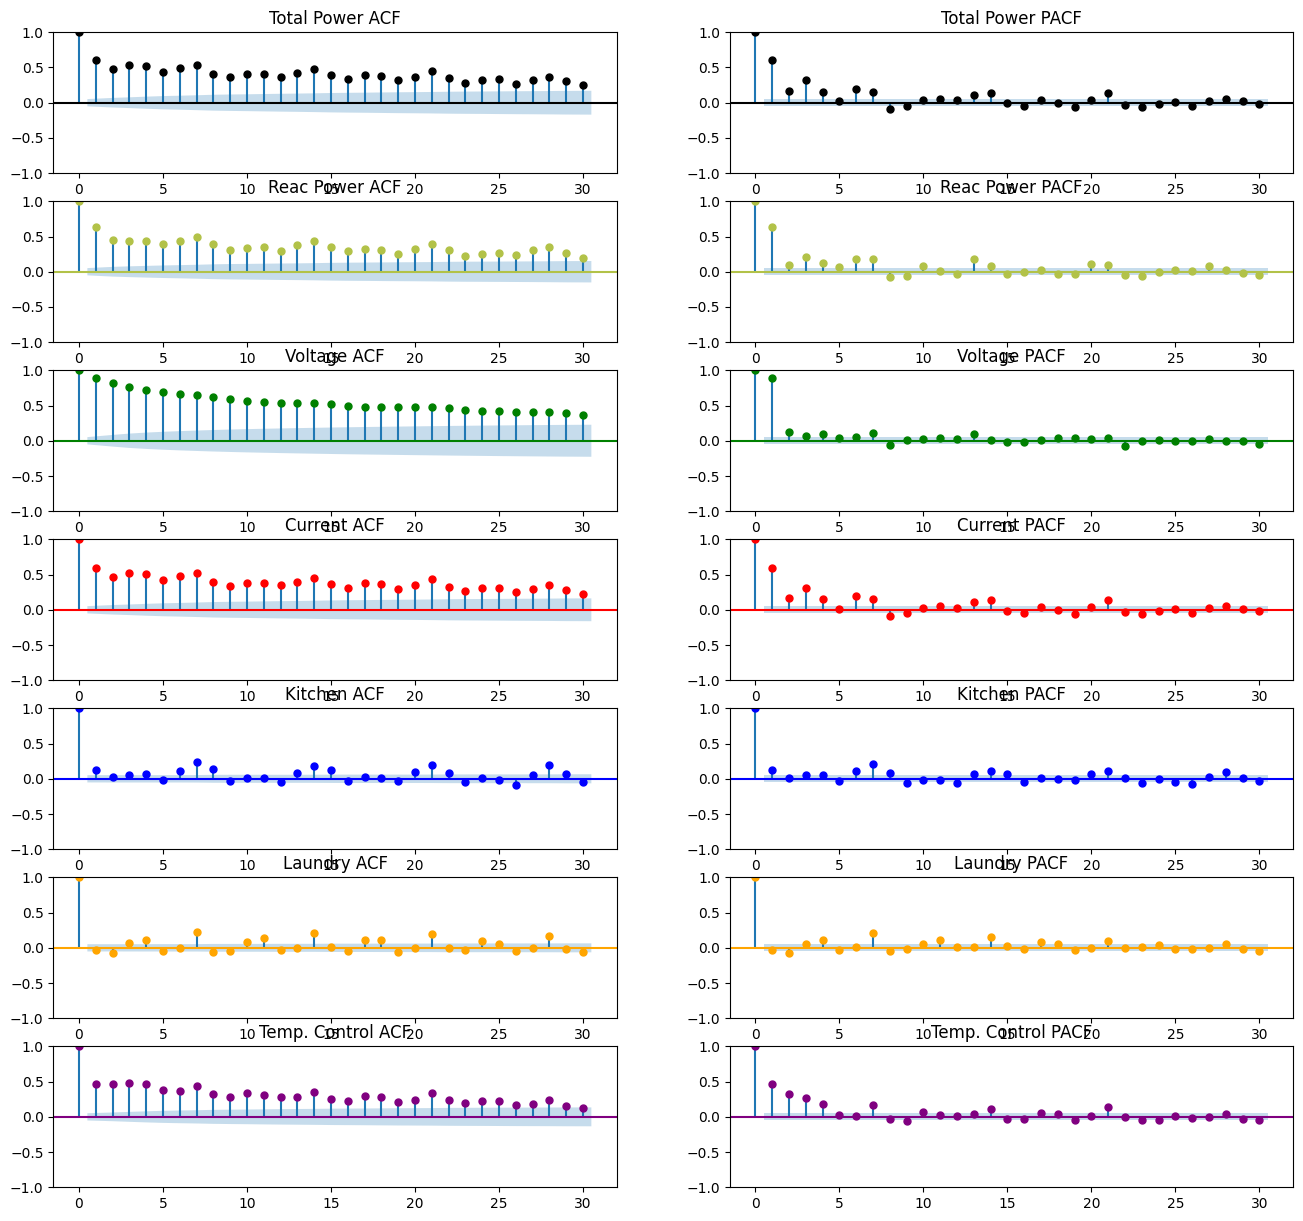

In [184]:
#Let´s check autocorrelation

n_lags = 30

figs, axs = plt.subplots(7, 2,figsize=(16,15))

f_tot_power.plot_acf(
    ax=axs[0,0],
    title='Total Power ACF',
    lags=n_lags,
    color='black'
)
f_tot_power.plot_pacf(
    ax=axs[0,1],
    title='Total Power PACF',
    lags=n_lags,
    color='black',
    method='ywm'
)
f_reac_power.plot_acf(
    ax=axs[1,0],
    title='Reac Power ACF',
    lags=n_lags,
    color='#B2C248'
)
f_reac_power.plot_pacf(
    ax=axs[1,1],
    title='Reac Power PACF',
    lags=n_lags,
    color='#B2C248',
    method='ywm'
)
f_voltage.plot_acf(
    ax=axs[2,0],
    title='Voltage ACF',
    lags=n_lags,
    color='green'
)
f_voltage.plot_pacf(
    ax=axs[2,1],
    title='Voltage PACF',
    lags=n_lags,
    color='green',
    method='ywm'
)
f_current.plot_acf(
    ax=axs[3,0],
    title='Current ACF',
    lags=n_lags,
    color='red'
)
f_current.plot_pacf(
    ax=axs[3,1],
    title='Current PACF',
    lags=n_lags,
    color='red',
    method='ywm'
)
f_kitchen.plot_acf(
    ax=axs[4,0],
    title='Kitchen ACF',
    lags=n_lags,
    color='blue'
)
f_kitchen.plot_pacf(
    ax=axs[4,1],
    title='Kitchen PACF',
    lags=n_lags,
    color='blue',
    method='ywm'
)
f_laundry.plot_acf(
    ax=axs[5,0],
    title='Laundry ACF',
    lags=n_lags,
    color='orange'
)
f_laundry.plot_pacf(
    ax=axs[5,1],
    title='Laundry PACF',
    lags=n_lags,
    color='orange',
    method='ywm'
)
f_temp_control.plot_acf(
    ax=axs[6,0],
    title='Temp. Control ACF',
    lags=n_lags,
    color='purple'
)
f_temp_control.plot_pacf(
    ax=axs[6,1],
    title='Temp. Control PACF',
    lags=n_lags,
    color='purple',
    method='ywm'
)
plt.show()



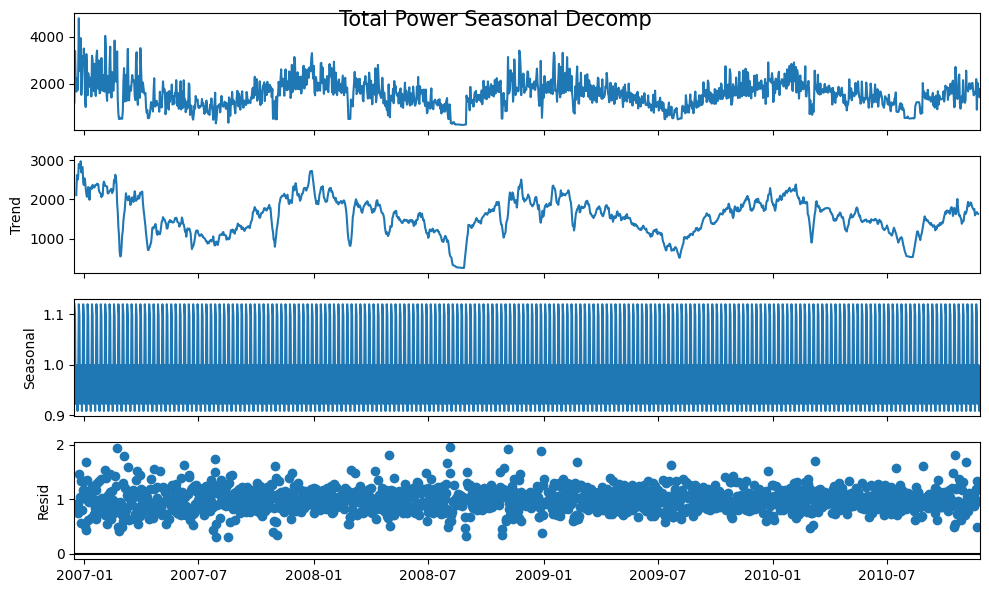

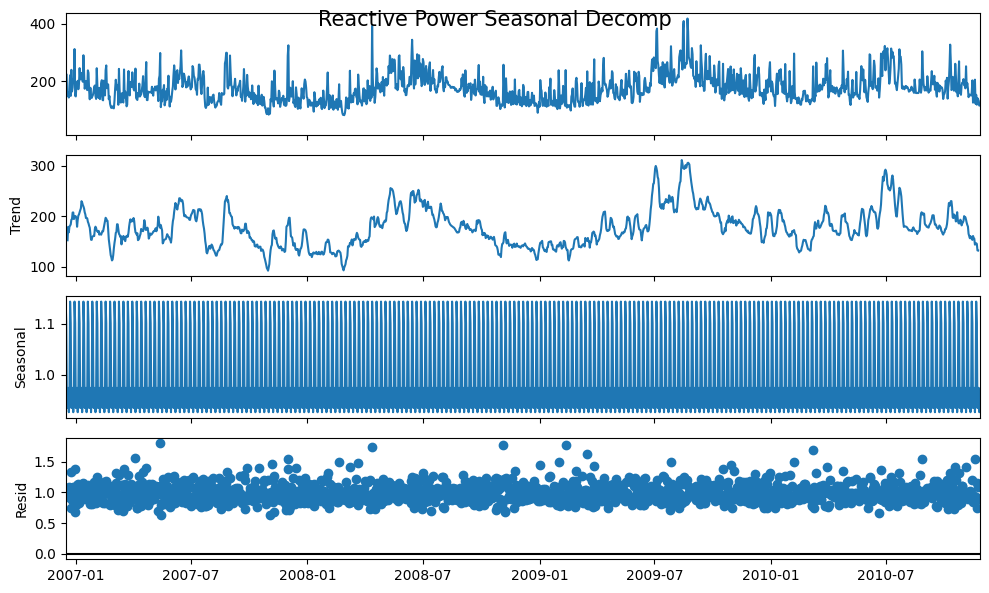

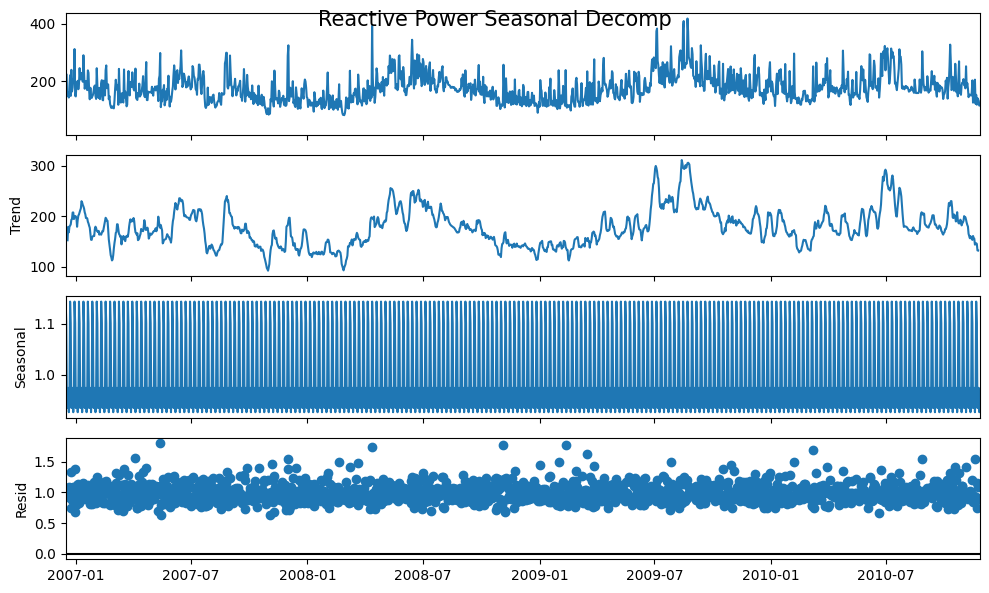

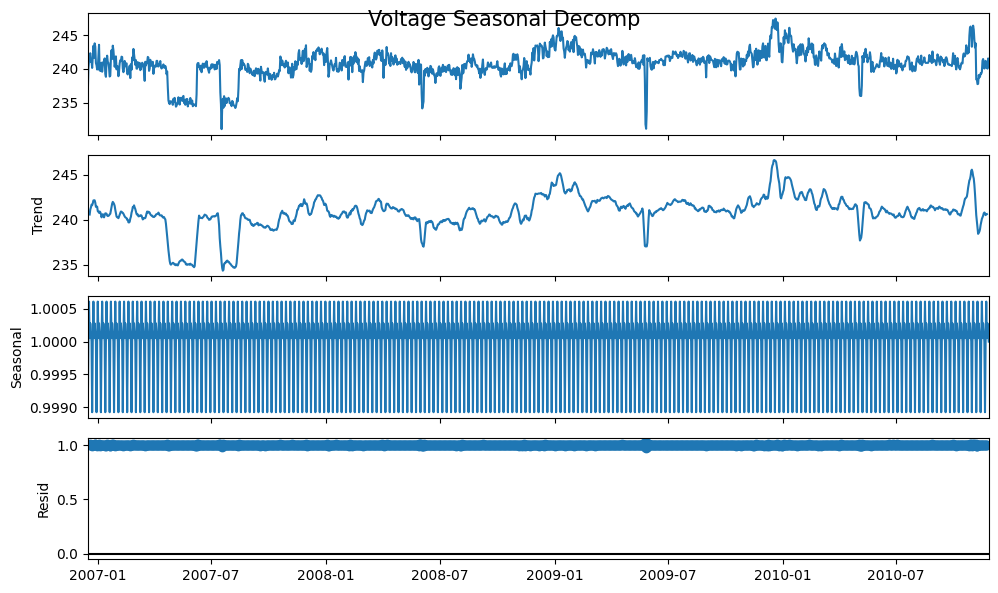

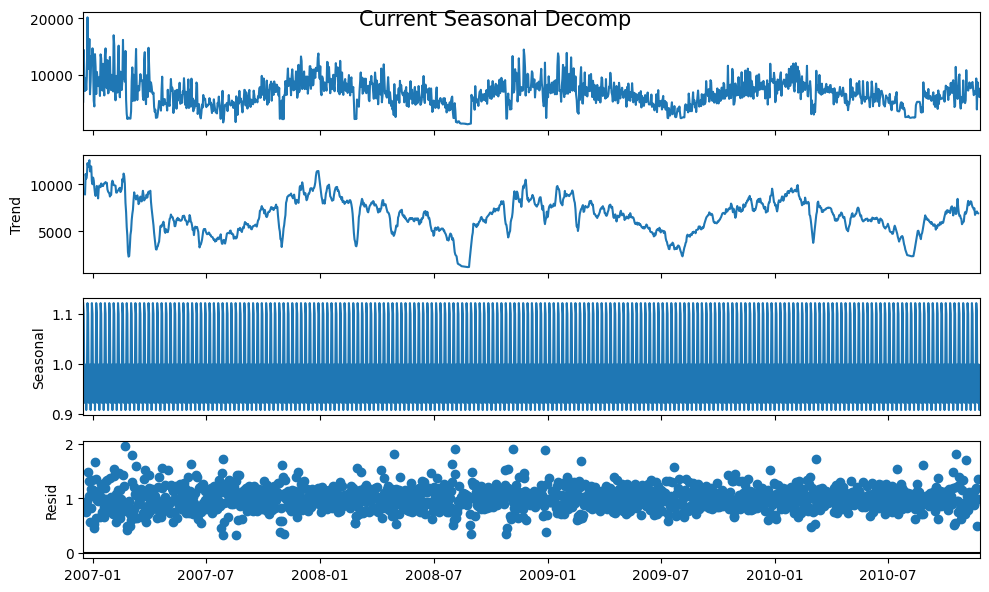

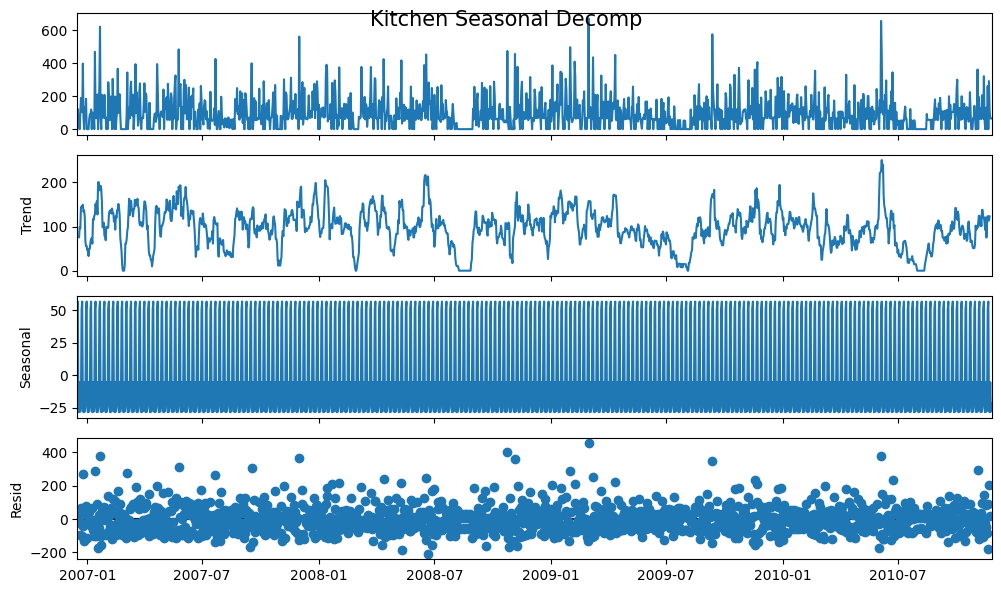

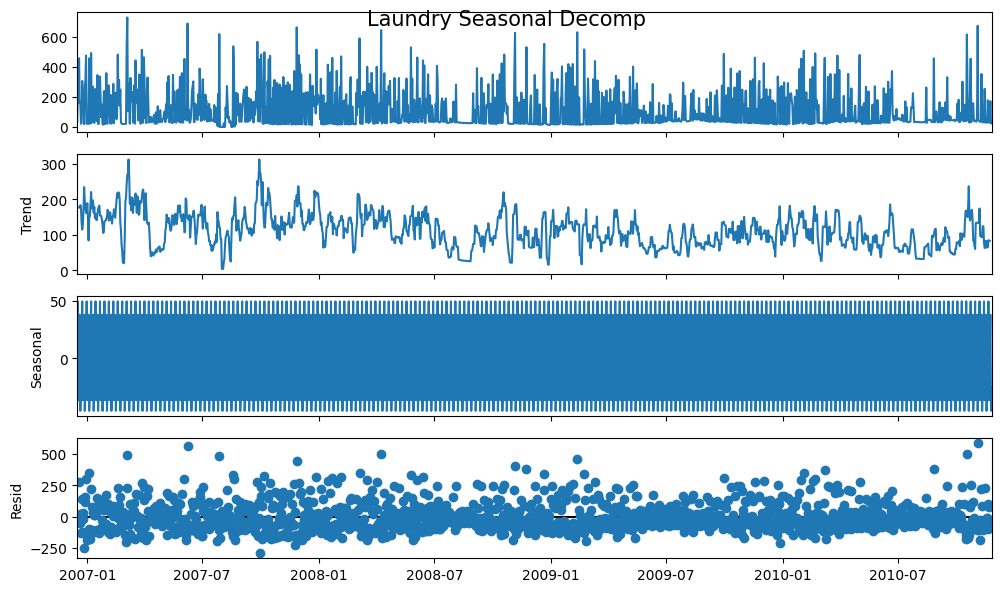

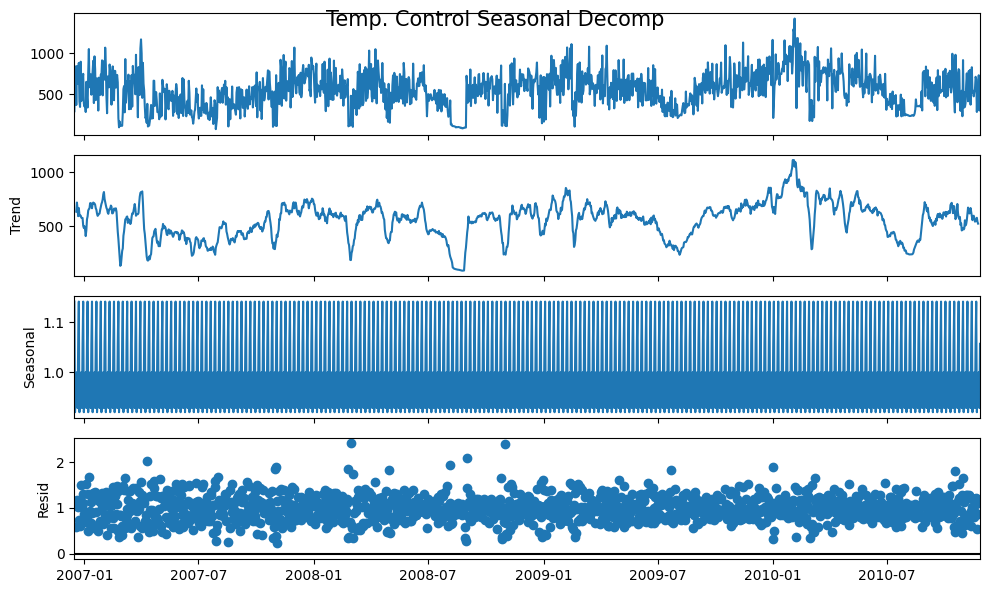

In [185]:
# Now let's decompose the series to check Time Series Components

plt.rc("figure",figsize=(10,6))
f_tot_power.seasonal_decompose(model='mul').plot()
plt.suptitle('Total Power Seasonal Decomp',size=15)

f_reac_power.seasonal_decompose(model='mul').plot()
plt.suptitle('Reactive Power Seasonal Decomp',size=15)

f_reac_power.seasonal_decompose(model='mul').plot()
plt.suptitle('Reactive Power Seasonal Decomp',size=15)

f_voltage.seasonal_decompose(model='mul').plot()
plt.suptitle('Voltage Seasonal Decomp',size=15)

f_current.seasonal_decompose(model='mul').plot()
plt.suptitle('Current Seasonal Decomp',size=15)

f_kitchen.seasonal_decompose(model='additive').plot()
plt.suptitle('Kitchen Seasonal Decomp',size=15)

f_laundry.seasonal_decompose(model='additive').plot()
plt.suptitle('Laundry Seasonal Decomp',size=15)

f_temp_control.seasonal_decompose(model='mul').plot()
plt.suptitle('Temp. Control Seasonal Decomp',size=15)

plt.show()

In [186]:
# Now let's check if each time serie is stationary or not

critical_pval = 0.05

# List of Forecaster objects
forecasters = [f_tot_power, f_reac_power, f_voltage, f_current, f_kitchen, f_laundry, f_temp_control]

# List of variable names
variables = ['Total Power', 'Reactive Power', 'Voltage', 'Current', 'Kitchen', 'Laundry', 'Temperature Control']

for forecaster, variable in zip(forecasters, variables):
    print('-' * 100)
    print(f'{variable} consumption results:')

    # ADF Test
    stat, pval, _, _, _, _ = forecaster.adf_test(full_res=True)

    print('the test-stat value is: {:.2f}'.format(stat))
    print('the p-value is {:.4f}'.format(pval))
    print('the series is {}'.format('stationary' if pval < critical_pval else 'NOT stationary'))
    print('-' * 30)

----------------------------------------------------------------------------------------------------
Total Power consumption results:
the test-stat value is: -3.70
the p-value is 0.0042
the series is stationary
------------------------------
----------------------------------------------------------------------------------------------------
Reactive Power consumption results:
the test-stat value is: -3.87
the p-value is 0.0023
the series is stationary
------------------------------
----------------------------------------------------------------------------------------------------
Voltage consumption results:
the test-stat value is: -3.75
the p-value is 0.0034
the series is stationary
------------------------------
----------------------------------------------------------------------------------------------------
Current consumption results:
the test-stat value is: -3.80
the p-value is 0.0030
the series is stationary
------------------------------
-------------------------------------

In [173]:
# Fill missing values with the value from previous observation

# define a function to copy previous' value and fill in the missing observation
def fill_missing(values):
    one_day = 60*24
    for row in range(df.shape[0]):
        for col in range(df.shape[1]):
            if np.isnan(values[row][col]):
                values[row,col] = values[row-one_day,col]

#convert to float
df = df.astype('float32')

# Call function
fill_missing(df.values)

# Check Na values
df.isnull().sum()


total_real_power     0
reactive_power       0
voltage              0
current_intensity    0
kitchen              0
laundry_room         0
temp_control         0
dtype: int64

In [174]:
# Normalize the feature columns

scaler = MinMaxScaler()
df_daily_scaled = scaler.fit_transform(df.iloc[:, 0:])

# Convert the scaled data back to a dataframe
features = df.columns[0:]
df_daily_scaled = pd.DataFrame(df_daily_scaled, columns=features)

# Display the head of the normalized dataframe and the missing values
print(df_daily_scaled.head())

   total_real_power  reactive_power   voltage  current_intensity   kitchen  \
0          0.211996        0.000000  0.315385           0.211006  0.000000   
1          0.694252        0.499028  0.550493           0.695226  0.181875   
2          0.431901        0.331329  0.620518           0.424618  0.095098   
3          0.313037        0.302994  0.667476           0.311508  0.075058   
4          0.436748        0.329256  0.686364           0.428075  0.000000   

   laundry_room  temp_control  
0      0.045090      0.162013  
1      0.345776      0.536762  
2      0.216451      0.566912  
3      0.627797      0.218615  
4      0.218680      0.568916  


In [176]:
# Convert the series to a supervised learning problem

# We will use the last 7 days of data to predict the next day
n_input_steps = 7

# Define the number of features
n_features = df_daily_scaled.shape[1]

# Convert the time series data into supervised learning data
X, y, timestamps = [], [], []
for i in range(n_input_steps, len(df_daily_scaled)):
    X.append(df_daily_scaled.iloc[i-n_input_steps:i].values)
    y.append(df_daily_scaled.iloc[i, 0])
    timestamps.append(df_daily_scaled.index[i])

X, y, timestamps = np.array(X), np.array(y), np.array(timestamps)

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test, timestamps_train, timestamps_test = train_test_split(
    X, y, timestamps, test_size=0.2, random_state=42, shuffle=False
)

# Print the shapes of the train and test sets
print('Training set shape:', X_train.shape)
print('Test set shape:', X_test.shape)

# last elements in the train and test sets
print('Last datetime index in training set:', timestamps_train[-1])
print('Last datetime index in test set:', timestamps_test[-1])


Training set shape: (1148, 7, 7)
Test set shape: (287, 7, 7)
Last datetime index in training set: 1154
Last datetime index in test set: 1441


In [177]:
# Define a function to create the LSTM model

def create_model(optimizer='adam'):
    model = Sequential()
    model.add(LSTM(100, input_shape=(7, 7))) # with 100 neurons
    model.add(Dense(1))
    model.compile(optimizer=optimizer, loss='mse')
    return model

# Wrap the model using the KerasRegressor
model = KerasRegressor(build_fn=create_model, verbose=1)

# Define the grid search parameters
param_grid = {
    'batch_size': [16, 32, 64],
    'epochs': [25, 50, 100],
    'optimizer': ['adam', 'rmsprop', 'Adadelta']
}

# Create the GridSearchCV object
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=3)

# Fit the grid search to the data
grid_result = grid.fit(X_train, y_train)

# Summarize results
print('Best: {} using {}'.format(grid_result.best_score_, grid_result.best_params_))
print('All results:')

# Save best parameters in a file
best_params = grid_result.best_params_
with open('best_params.json', 'w') as file:
    json.dump(best_params, file)

#print results
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print('{} ({}) with: {}'.format(mean, stdev, param))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:915: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/50
36/36 [==============================] - 2s 8ms/step - loss: 0.0206
Epoch 2/50
36/36 [==============================] - 0s 8ms/step - loss: 0.0110
Epoch 3/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 4/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0106
Epoch 5/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 6/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 7/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0105
Epoch 8/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 9/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0104
Epoch 10/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 11/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0100
Epoch 12/50
36/36 [==============================] - 0s 9ms/step - loss: 0.0103
Epoch 13/50
36/36 [==============================

In [178]:
# Load and print the best parameters to verify the keys
with open('best_params.json', 'r') as f:
    best_params = json.load(f)
print(best_params)

{'batch_size': 32, 'epochs': 50, 'optimizer': 'Adadelta'}


In [179]:
# Now let's forecast using the best parameters

# Load the best parameters from the file
with open('best_params.json', 'r') as file:
    best_params = json.load(file)

# Define the LSTM model using the loaded best parameters
model = Sequential()
model.add(LSTM(units=100, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(optimizer=best_params['optimizer'], loss='mse')

# Fit the model
history = model.fit(X_train, y_train, epochs=best_params['epochs'], batch_size=best_params['batch_size'], verbose=1, validation_data=(X_test, y_test))

# Access training and validation losses from the history object
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Forecast
y_pred = model.predict(X_test)

#Save the model to use to forecast
model.save('my_model.h5')

# Calculate RMSE and MAE
rmse = sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print('Test MAE: %.3f' % mae)
print('Test RMSE: %.3f' % rmse)

Epoch 1/50
36/36 [==============================] - 2s 18ms/step - loss: 0.0766 - val_loss: 0.0556
Epoch 2/50
36/36 [==============================] - 0s 12ms/step - loss: 0.0759 - val_loss: 0.0549
Epoch 3/50
36/36 [==============================] - 0s 10ms/step - loss: 0.0751 - val_loss: 0.0543
Epoch 4/50
36/36 [==============================] - 0s 13ms/step - loss: 0.0743 - val_loss: 0.0536
Epoch 5/50
36/36 [==============================] - 1s 16ms/step - loss: 0.0736 - val_loss: 0.0529
Epoch 6/50
36/36 [==============================] - 1s 16ms/step - loss: 0.0728 - val_loss: 0.0522
Epoch 7/50
36/36 [==============================] - 1s 17ms/step - loss: 0.0720 - val_loss: 0.0515
Epoch 8/50
36/36 [==============================] - 1s 16ms/step - loss: 0.0712 - val_loss: 0.0508
Epoch 9/50
36/36 [==============================] - 1s 16ms/step - loss: 0.0704 - val_loss: 0.0501
Epoch 10/50
36/36 [==============================] - 1s 18ms/step - loss: 0.0696 - val_loss: 0.0494
Epoch 11/

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Test MAE: 0.131
Test RMSE: 0.153


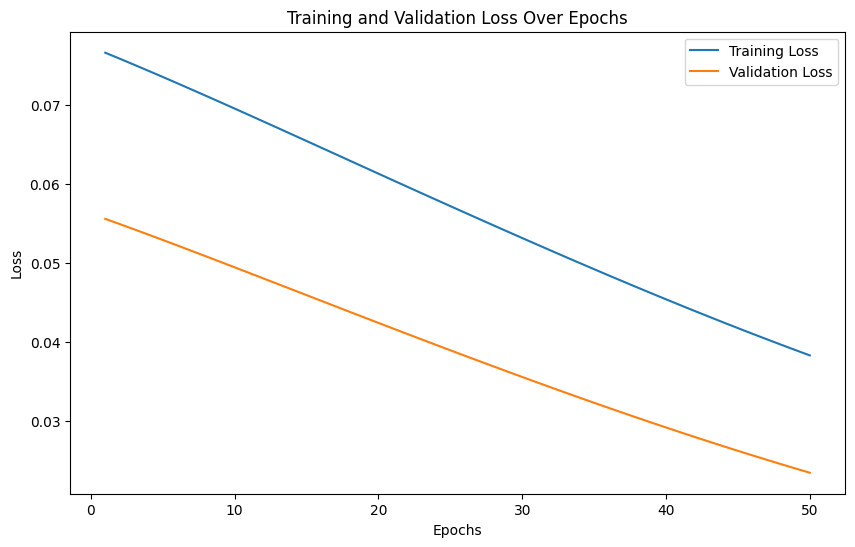

In [180]:
# Plot training and validation losses over epochs
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

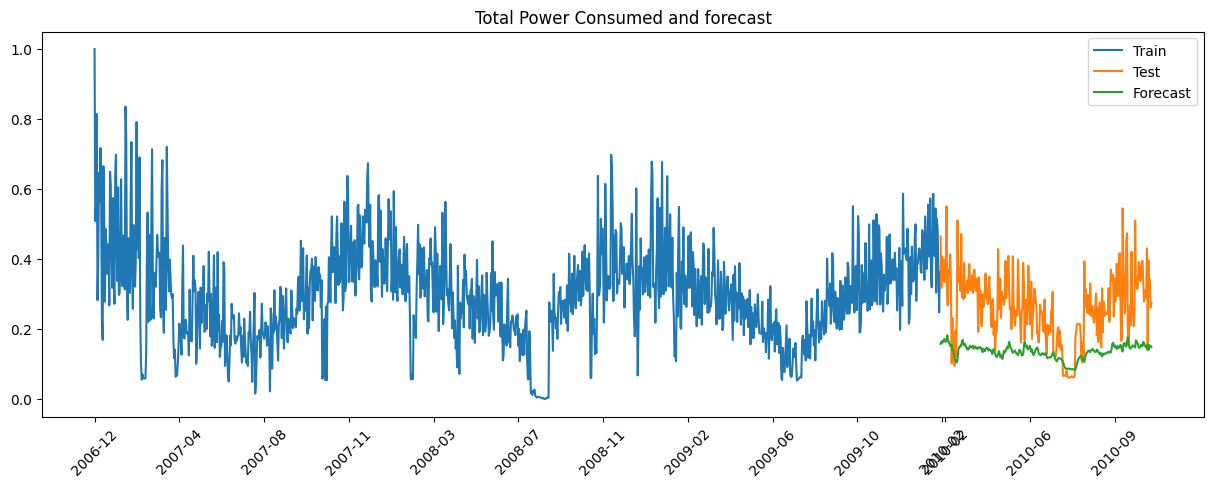

In [181]:
# Plot the actual vs predicted values



# Convert datetime index to a list of strings
date_strings_train = [str(date) for date in df.index[:timestamps_train[-1]]]
date_strings_test = [str(date) for date in df.index[timestamps_train[-1]:]]

plt.figure(figsize=(15, 5))
plt.plot(date_strings_train[:-6], y_train, label='Train')
plt.plot(date_strings_test[:-1], y_test, label='Test')
plt.plot(date_strings_test[:-1], y_pred, label='Forecast')
plt.title('Total Power Consumed and forecast')

plt.legend()

# Include some dates along the x-axis with month and year
n = max(len(date_strings_train) // 10, 1)
xticks_positions = list(range(0, len(date_strings_train), n)) + list(range(len(date_strings_train), len(date_strings_train) + len(date_strings_test), n))
xticks_labels = [date_strings_train[i] for i in range(0, len(date_strings_train), n)] + [date_strings_test[i] for i in range(0, len(date_strings_test), n)]

# Format dates
xticks_labels = [pd.to_datetime(label).strftime('%Y-%m') for label in xticks_labels]

plt.xticks(xticks_positions, xticks_labels, rotation=45)

plt.show()


# References

We worked on the problem set as independently as possible and got assistance from ChatGPT and Julius.ai when needed. We utilized the following resources to get a deeper understanding of the challenges posed by the problem set:
- Dive into Deep Learning - https://d2l.ai/
- Peixeiro, Marco. Time series forecasting in python,  ISBN 9781617299889, 2022. Available at https://www.manning.com/books/time-series-forecasting-in-python-book
- Multivariate Time Series Forecasting with LSTMs in Keras - https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
- Exploring the LSTM Neural Network Model for Time Series - https://towardsdatascience.com/exploring-the-lstm-neural-network-model-for-time-series-8b7685aa8cf
- Multivariate Multi-step Time Series Forecasting using Stacked LSTM sequence to sequence Autoencoder in Tensorflow 2.0 / Keras - https://www.analyticsvidhya.com/blog/2020/10/multivariate-multi-step-time-series-forecasting-using-stacked-lstm-sequence-to-sequence-autoencoder-in-tensorflow-2-0-keras/#wait_approval
- MULTIVARIATE TIME SERIES FORECASTING USING LSTM - https://medium.com/@786sksujanislam786/multivariate-time-series-forecasting-using-lstm-4f8a9d32a509
- Multiple Series? Forecast Them together with any Sklearn Model - https://towardsdatascience.com/multiple-series-forecast-them-together-with-any-sklearn-model-96319d46269
- Guide to Time Series Analysis with Python — 1: Analysis Techniques and Baseline Model - https://buse-koseoglu13.medium.com/guide-to-time-series-analysis-with-python-1-analysis-techniques-and-baseline-model-59e12fdd2eba
-